In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
path = 'plant_segmentation/dataset/arabidopsis/*/*'
imagepath = 'plant_segmentation/dataset/arabidopsis/images/*'
maskspath = 'plant_segmentation/dataset/arabidopsis/masks/'

In [4]:
heigh = 256

In [5]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   mask = maskspath + get_mask(file_path)
   mask = tf.io.read_file(mask)
   mask = tf.image.decode_png(mask)
   cond = tf.greater_equal(mask,1)
   mask = tf.where(cond,1,0)
   return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   print(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*8,heigh*8,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*8,heigh*8,1),seed=int(seed))
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.float32)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(64)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [6]:
dataset = tf_dataset(imagepath,learning = True)
dataset
valdataset = tf_dataset(imagepath,learning = True)
valdataset = valdataset.batch(4)

In [7]:
len(dataset)

128

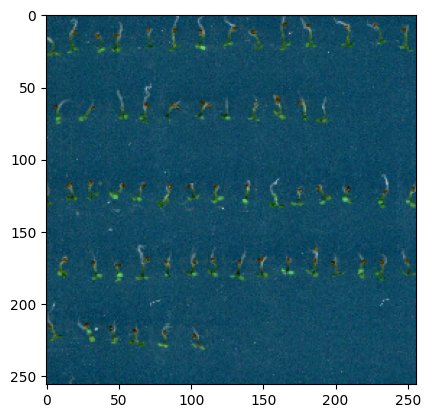

tf.Tensor([], shape=(0,), dtype=float32)


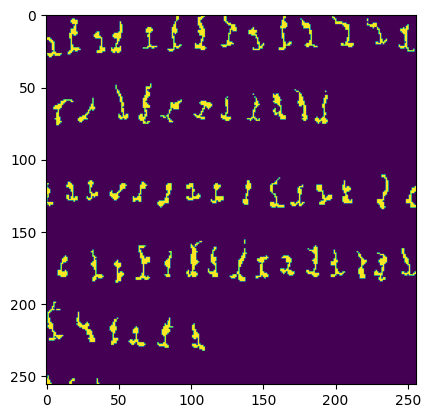

In [8]:
for image,mask in dataset.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        print(mask[mask > 1])

In [9]:
#unet
#encoder x:
def encoder_x(x,n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

#decoder_x:
def decoder_x(x,skip_connections,n_filters):
    x = tf.keras.layers.concatenate([x,skip_connections])
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

#output
def output(x):
    return tf.keras.layers.Conv2DTranspose(1,3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False,activation='sigmoid')(x)


def buildmodel():
    inputlayer = tf.keras.layers.Input(shape=(256,256,3))
    print(inputlayer)
    e1 = encoder_x(inputlayer,64)
    e2 = encoder_x(e1,128)
    e3 = encoder_x(e2,256)
    e4 = encoder_x(e3,512)
    e5 = encoder_x(e4,512)
    e6 = encoder_x(e5,512)
    e7 = encoder_x(e6,512)
    x = decoder_x(e7,e7,512)
    x = decoder_x(x,e6,512)
    x = decoder_x(x,e5,512)
    x = decoder_x(x,e4,256)
    x = decoder_x(x,e3,128)
    x = decoder_x(x,e2,64)
    x = tf.keras.layers.concatenate([x,e1])
    outputlayer = output(x)
    print(outputlayer)
    
    unet_model = tf.keras.Model(inputlayer, outputlayer, name="U-Net")

    return unet_model

In [10]:
#dice coef
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))

def custom_dice_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) * 0.5 + tf.keras.losses.BinaryCrossentropy()(y_true,y_pred)

In [11]:
model = buildmodel()
model.compile(optimizer = 'adam', loss = [custom_dice_loss], metrics = ['accuracy',[dice_coef]])
#tf.keras.utils.plot_model(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [12]:
callback =[tf.keras.callbacks.EarlyStopping(min_delta=0.01,patience=2,verbose=1)
,tf.keras.callbacks.ModelCheckpoint(filepath='models/model',save_best_only=True,monitor='loss',verbose=1)
]

In [13]:
model_history = model.fit(dataset.batch(4),
                              epochs=12,
                              validation_data=valdataset,
                              validation_steps=4,
                              class_weight={0:1,1:10},
                              callbacks=callback)

Epoch 1/12
32/32 [==============================] - ETA: 0s - loss: 1.4076 - accuracy: 0.8484 - dice_coef: 0.2417
Epoch 1: loss improved from inf to 1.40765, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 30s 751ms/step - loss: 1.4076 - accuracy: 0.8484 - dice_coef: 0.2417 - val_loss: 2.0734 - val_accuracy: 0.9359 - val_dice_coef: 0.0261
Epoch 2/12
32/32 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.9505 - dice_coef: 0.4868
Epoch 2: loss improved from 1.40765 to 0.65340, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 29s 756ms/step - loss: 0.6534 - accuracy: 0.9505 - dice_coef: 0.4868 - val_loss: 0.5796 - val_accuracy: 0.9428 - val_dice_coef: 0.2060
Epoch 3/12
32/32 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.9607 - dice_coef: 0.5917
Epoch 3: loss improved from 0.65340 to 0.52672, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 31s 830ms/step - loss: 0.5267 - accuracy: 0.9607 - dice_coef: 0.5917 - val_loss: 0.4608 - val_accuracy: 0.9483 - val_dice_coef: 0.3512
Epoch 4/12
32/32 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.9646 - dice_coef: 0.6274
Epoch 4: loss improved from 0.52672 to 0.47861, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 33s 891ms/step - loss: 0.4786 - accuracy: 0.9646 - dice_coef: 0.6274 - val_loss: 0.4430 - val_accuracy: 0.9503 - val_dice_coef: 0.3916
Epoch 5/12
32/32 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.9669 - dice_coef: 0.6628
Epoch 5: loss improved from 0.47861 to 0.44347, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 28s 716ms/step - loss: 0.4435 - accuracy: 0.9669 - dice_coef: 0.6628 - val_loss: 0.3636 - val_accuracy: 0.9566 - val_dice_coef: 0.5139
Epoch 6/12
32/32 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.9677 - dice_coef: 0.6836
Epoch 6: loss improved from 0.44347 to 0.42369, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 28s 715ms/step - loss: 0.4237 - accuracy: 0.9677 - dice_coef: 0.6836 - val_loss: 0.3739 - val_accuracy: 0.9579 - val_dice_coef: 0.5030
Epoch 7/12
32/32 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.9705 - dice_coef: 0.6958
Epoch 7: loss improved from 0.42369 to 0.39097, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


32/32 [==============================] - 29s 769ms/step - loss: 0.3910 - accuracy: 0.9705 - dice_coef: 0.6958 - val_loss: 0.3547 - val_accuracy: 0.9582 - val_dice_coef: 0.5458
Epoch 7: early stopping


In [25]:
test = tf_dataset('cropped/AAE_0073.png',learning=False)
test

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)


<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)>

In [26]:
pred_mask = model.predict(test)

1/1 [==============================] - 0s 246ms/step


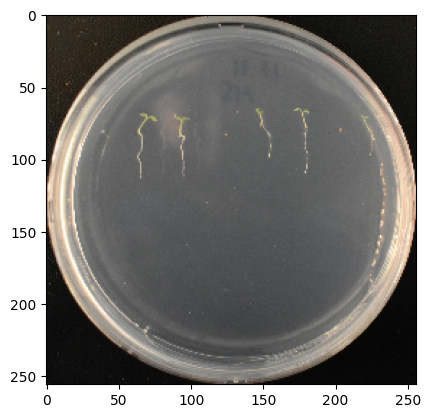

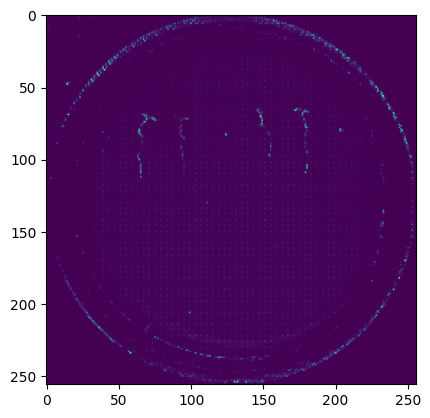

In [16]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])

In [17]:
test_on_the_same_data = tf_dataset('plant_segmentation/dataset/arabidopsis/images/140925 8-8 047.png',learning=True)
pred_mask = model.predict(test_on_the_same_data.batch(1))

8/8 [==============================] - 3s 34ms/step


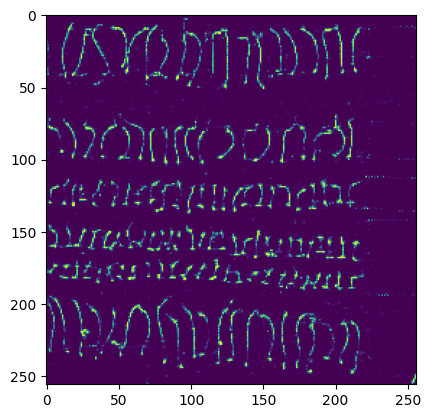

In [18]:
plt.imshow(pred_mask[0,:,:,:])

In [19]:
path = 'castom-masks/ds0/'
imagepath = path + 'img/*'
maskspath = path + 'masks_machine/'


In [20]:
newdata = tf_dataset(imagepath,learning = True)

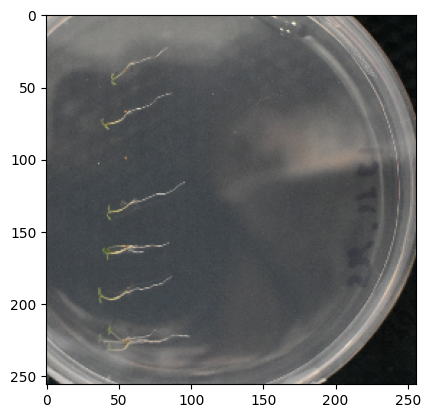

tf.Tensor([], shape=(0,), dtype=float32)


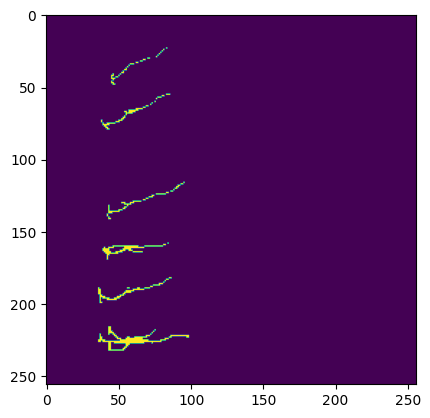

In [21]:
for image,mask in newdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        print(mask[mask > 1])

In [22]:
model_history = model.fit(newdata.batch(4),
                              epochs=10,
                              callbacks=callback)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9878 - dice_coef: 0.3636WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 1: loss improved from 0.39097 to 0.37432, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 506ms/step - loss: 0.3743 - accuracy: 0.9878 - dice_coef: 0.3636
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9930 - dice_coef: 0.5217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 2: loss improved from 0.37432 to 0.26953, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 509ms/step - loss: 0.2695 - accuracy: 0.9930 - dice_coef: 0.5217
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9935 - dice_coef: 0.5722WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 3: loss improved from 0.26953 to 0.24150, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 509ms/step - loss: 0.2415 - accuracy: 0.9935 - dice_coef: 0.5722
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9944 - dice_coef: 0.6247WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 4: loss improved from 0.24150 to 0.21263, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 508ms/step - loss: 0.2126 - accuracy: 0.9944 - dice_coef: 0.6247
Epoch 5/10
34/34 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9946 - dice_coef: 0.6544WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 5: loss improved from 0.21263 to 0.19757, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 507ms/step - loss: 0.1976 - accuracy: 0.9946 - dice_coef: 0.6544
Epoch 6/10
34/34 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9949 - dice_coef: 0.6679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 6: loss improved from 0.19757 to 0.18960, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 510ms/step - loss: 0.1896 - accuracy: 0.9949 - dice_coef: 0.6679
Epoch 7/10
34/34 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9951 - dice_coef: 0.6769WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 7: loss improved from 0.18960 to 0.18478, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 508ms/step - loss: 0.1848 - accuracy: 0.9951 - dice_coef: 0.6769
Epoch 8/10
34/34 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9950 - dice_coef: 0.6832WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 8: loss improved from 0.18478 to 0.18330, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 506ms/step - loss: 0.1833 - accuracy: 0.9950 - dice_coef: 0.6832
Epoch 9/10
34/34 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9954 - dice_coef: 0.7099WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 9: loss improved from 0.18330 to 0.16754, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 509ms/step - loss: 0.1675 - accuracy: 0.9954 - dice_coef: 0.7099
Epoch 10/10
34/34 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9953 - dice_coef: 0.7117WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,dice_coef



Epoch 10: loss improved from 0.16754 to 0.16714, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


34/34 [==============================] - 21s 504ms/step - loss: 0.1671 - accuracy: 0.9953 - dice_coef: 0.7117


In [45]:
test = tf_dataset('cropped/AAE_0032.png',learning=False)
pred_mask = model.predict(test)

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)
1/1 [==============================] - 0s 221ms/step


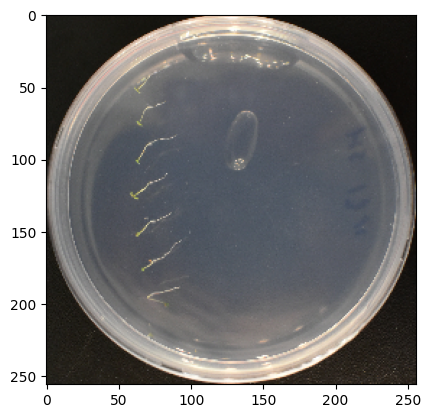

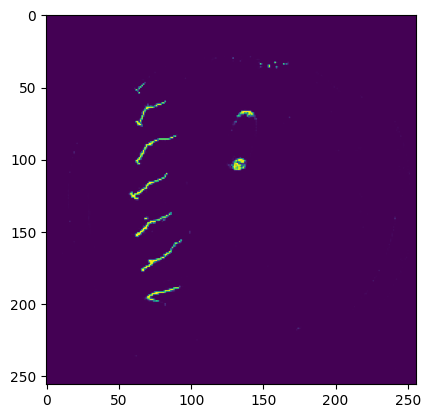

In [46]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])